<a href="https://colab.research.google.com/github/danangcrysnanto/bovine-graphs-mapping/blob/master/part1_varselect/analysis/part1_human_bovine_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comparison between cattle graphs and human graphs

We conducted additional analysis to compare our cattle graphs with human graphs. Using sequence variants from 1000 human genomes project, we characterized graphs augmented with variants from four representative (and genetically distinct) human populations (YRI- African, GBR- European, STU- South Asia, and JPT- East Asia).

In [0]:
#loading required library
library(tidyverse)
library(magrittr)

In [0]:
## We download data from github with this base url 
basepath <- "https://raw.githubusercontent.com/danangcrysnanto/bovine-graphs-mapping/master/part1_varselect/result/result_human"


### Plot relationship among samples with PCA

In [4]:
## Looking at the four selected populations
## PCA performed with plink v1.9 ~2500 axis
## Plot the first and second axis of eigen vectors
datall   <- read.table(url(file.path(basepath,"all_1kg_pca.eigenvec")),header=TRUE,stringsAsFactors = FALSE)
head(datall)

,fam,sample,pc1,pc2,pc3,population
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,0,HG00096,-0.0116463,0.0249046,0.0148913,GBR
2,0,HG00097,-0.0117540,0.0258029,0.0147789,GBR
3,0,HG00099,-0.0117979,0.0257849,0.0147423,GBR
4,0,HG00100,-0.0115851,0.0262769,0.0151320,GBR
5,0,HG00101,-0.0116067,0.0250128,0.0149661,GBR
6,0,HG00102,-0.0118380,0.0251263,0.0139783,GBR


In [7]:
## Calculate proportion explained from each axis from eigen value
### ratio should be based on the eigen val
egval  <- read.table(url(file.path(basepath,"all_1kg_pca.eigenval")),header=FALSE)
colnames(egval)  <- "valabs"
egval$vaprop  <- egval$valabs*100/sum(egval$valabs)
head(egval)

,valabs,vaprop
,<dbl>,<dbl>
1,44.81190,1.7672761
2,14.15520,0.5582478
3,5.74715,0.2266541
4,4.11049,0.1621081
5,3.74662,0.1477579
6,2.82470,0.1113995


First axis explained 1.77 % of the variations and second axis explained 0.56% from the total variation

Warning message:
“Removed 102 rows containing missing values (geom_point).”


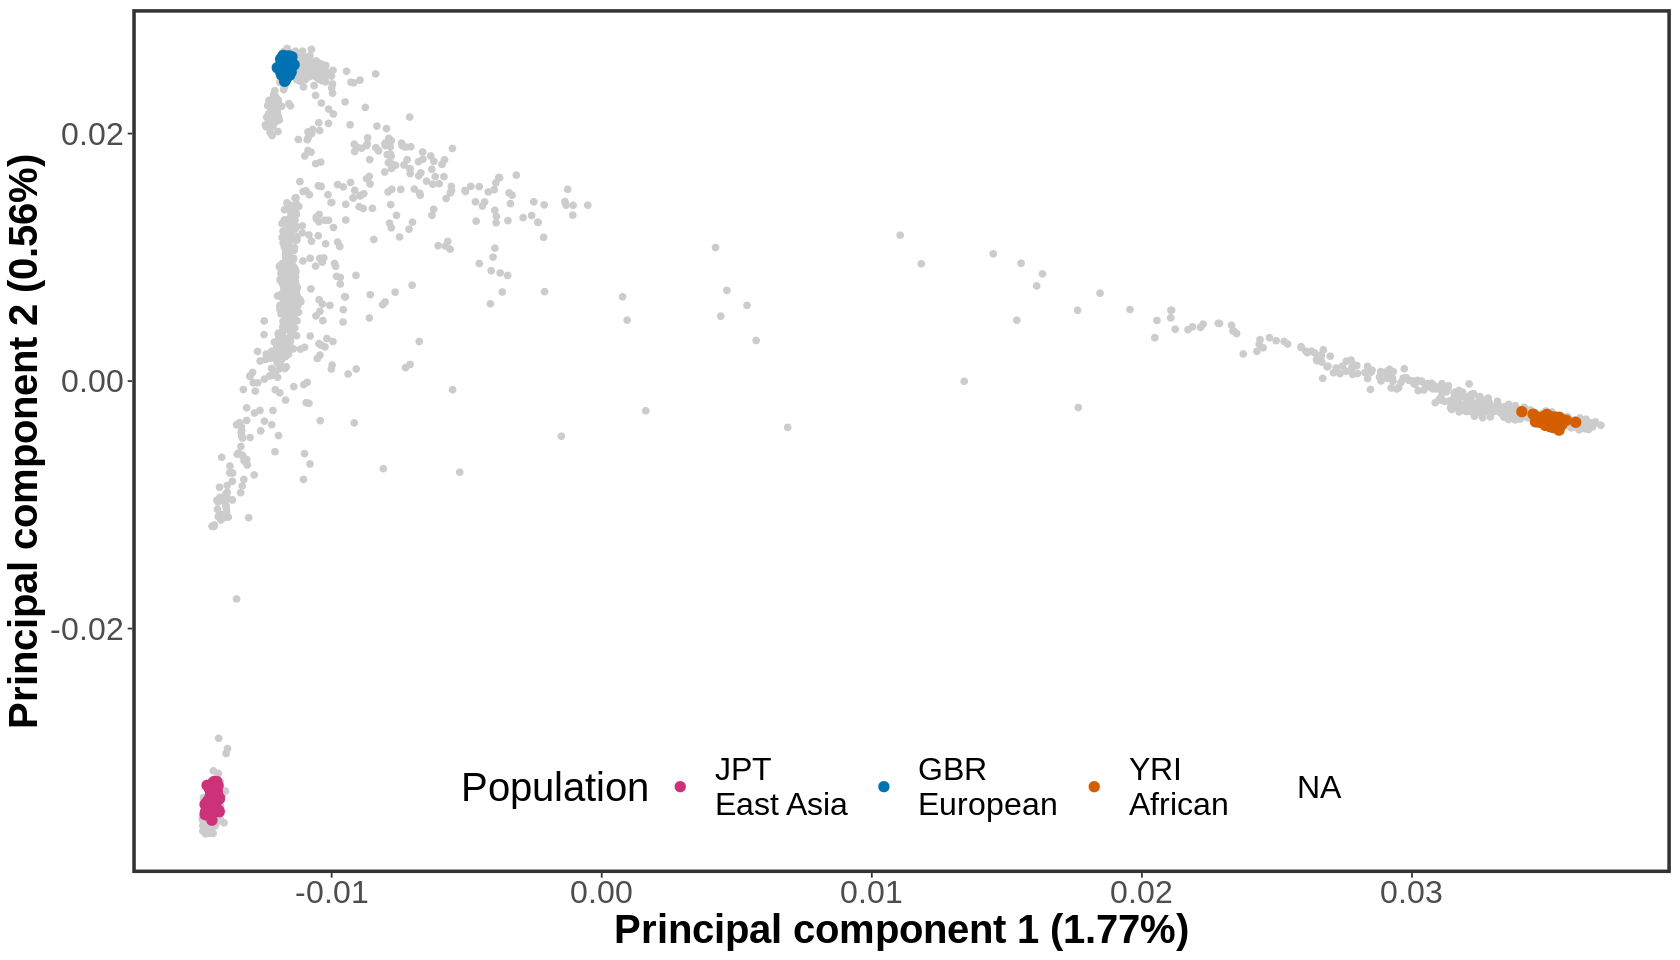

In [9]:
## select four population considered in this study
options(repr.plot.width=14, repr.plot.height=8)


datsel  <- datall  %>% filter(population %in% c("GBR","ITU","YRI","JPT"))
datsel$population  <- factor(datsel$population,levels=c("JPT","GBR","STU","YRI"),
                                       labels=c("JPT\nEast Asia","GBR\nEuropean","STU\nSouth Asia","YRI\nAfrican"))

pl1  <- ggplot()+
geom_point(data=datall,aes(x=pc1,y=pc2),col="grey80",size=1.5)+
geom_point(data=datsel,aes(x=pc1,y=pc2,col=population),size=2.5)+
theme_bw()+
theme(panel.border = element_rect(size=2),
      text=element_text(size=24),
      axis.title=element_text(face="bold"),
      panel.grid=element_blank(),
      legend.pos=c(0.5,0.1),
      legend.direction="horizontal")+
scale_colour_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))+
labs(x="Principal component 1 (1.77%)",y="Principal component 2 (0.56%)",col="Population")

pl1

### Plot nucleotide diversity
Nucleotide diversity (phi) calculated based on the vcftools with 10 kb non-overlapped windows

In [11]:
datdiv <- read.table(url(file.path(basepath,"phi_human.tsv")),header=FALSE,stringsAsFactors = FALSE)
colnames(datdiv) <- c("phi","pop")
head(datdiv)

,phi,pop
,<dbl>,<chr>
1,3.26028e-06,GBR
2,3.78848e-05,GBR
3,1.31504e-05,GBR
4,8.76692e-06,GBR
5,2.19780e-06,GBR
6,6.50841e-06,GBR


In [0]:
datsum  <- datdiv %>% group_by(pop)  %>% summarise(nc=mean(phi))
datdiv$pop <- factor(datdiv$pop,levels=c("JPT","GBR","STU","YRI"))

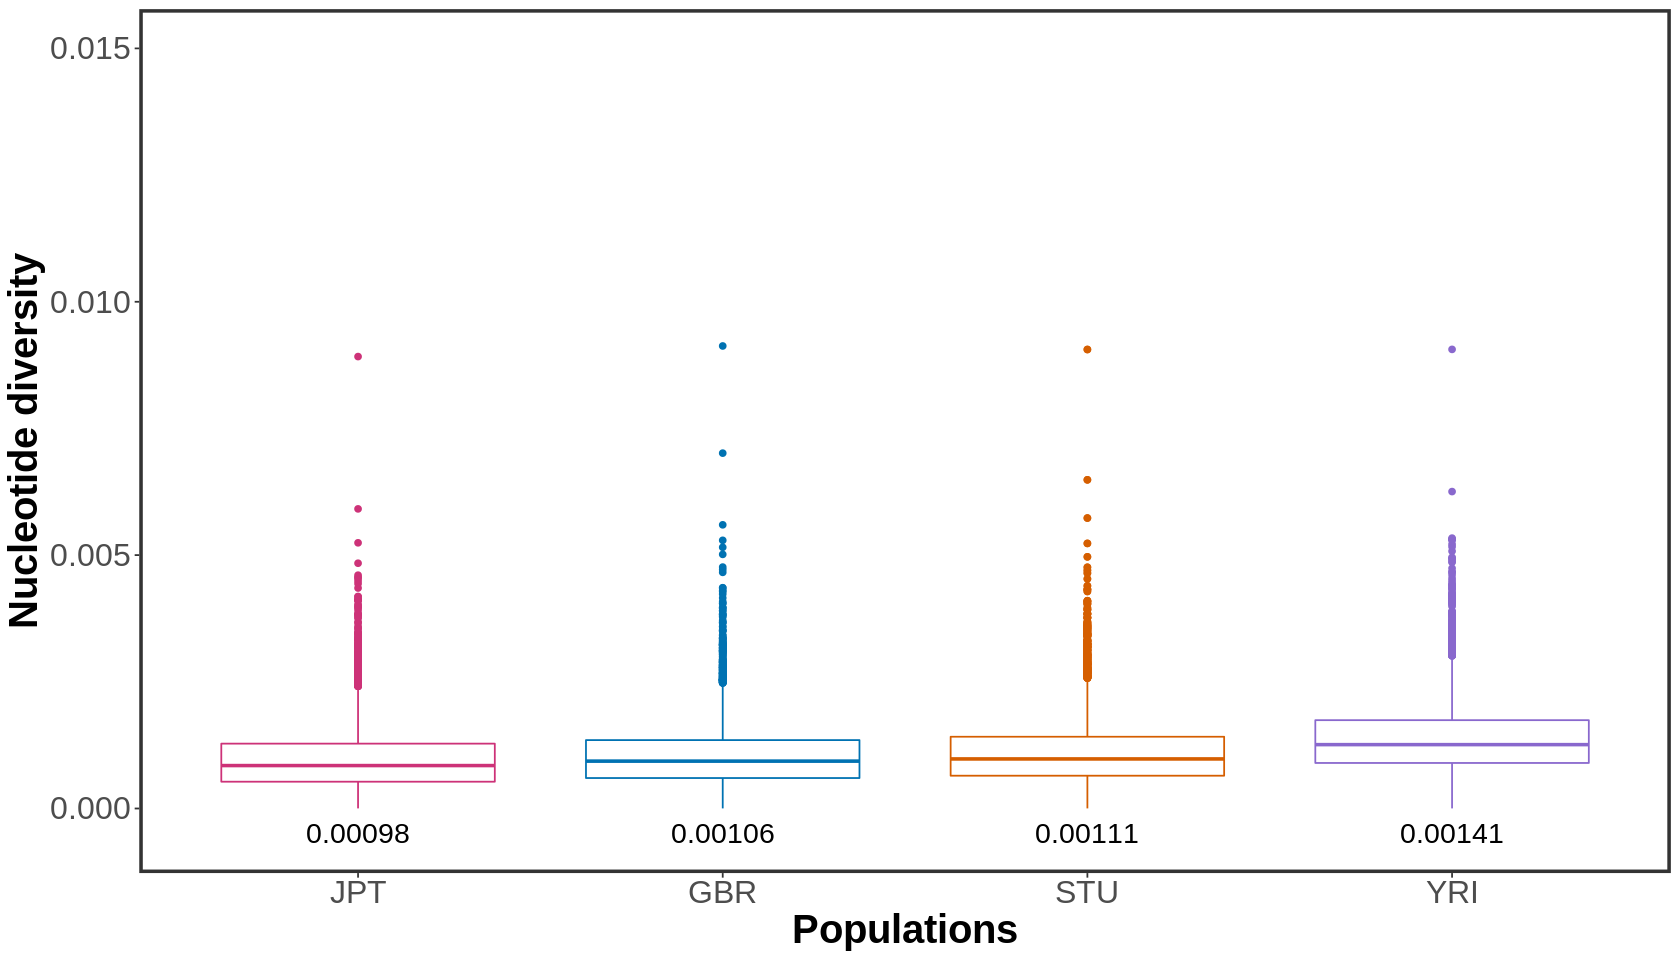

In [13]:
pl2  <- ggplot(datdiv,aes(x=pop,y=phi))+
  geom_boxplot(aes(col=pop),show.legend=FALSE)+
  geom_text(data=datsum,aes(x=pop,y=-0.0005,label=round(nc,5)), inherit.aes = FALSE,size=6)+
  theme_bw()+
  theme(panel.border = element_rect(size=2),
        text=element_text(size=24),
        axis.title=element_text(face="bold"),
        panel.grid = element_blank(),
        strip.background = element_blank(),
        strip.text = element_text(size=20))+
  scale_y_continuous(limits=c(-0.0005,0.015))+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))+
  labs(x="Populations",y="Nucleotide diversity")

pl2

### Plot graph mapping performance 
We constructed series of graphs from four human population with filter on allele frequency. We then simulated 10 millions reads from selected samples from each population. Then, we map simulated reads to all graphs from corresponding population. We calculated and plotted the mapping error as indicated below.

In [14]:
# the data consists of 4 columns with population, af threshold, total incorrect mapping, and mapping type
## subset to include only paired end
dathum <- read.table(url(file.path(basepath,"dathum_freq.tsv")),stringsAsFactors = FALSE,header=TRUE)
dathum_pe  <- dathum  %>% select(humpop,afcor,pecor2)
dathum_pe$maptype  <- "pe"
colnames(dathum_pe)  <- c("humpop","af","incor2","maptype")
head(dathum_pe)

,humpop,af,incor2,maptype
,<chr>,<dbl>,<dbl>,<chr>
1,GBR,0.00,0.3209200,pe
2,JPT,0.00,0.3121700,pe
3,STU,0.00,0.3238400,pe
4,YRI,0.00,0.3322025,pe
5,GBR,0.01,0.3209150,pe
6,JPT,0.01,0.3121525,pe


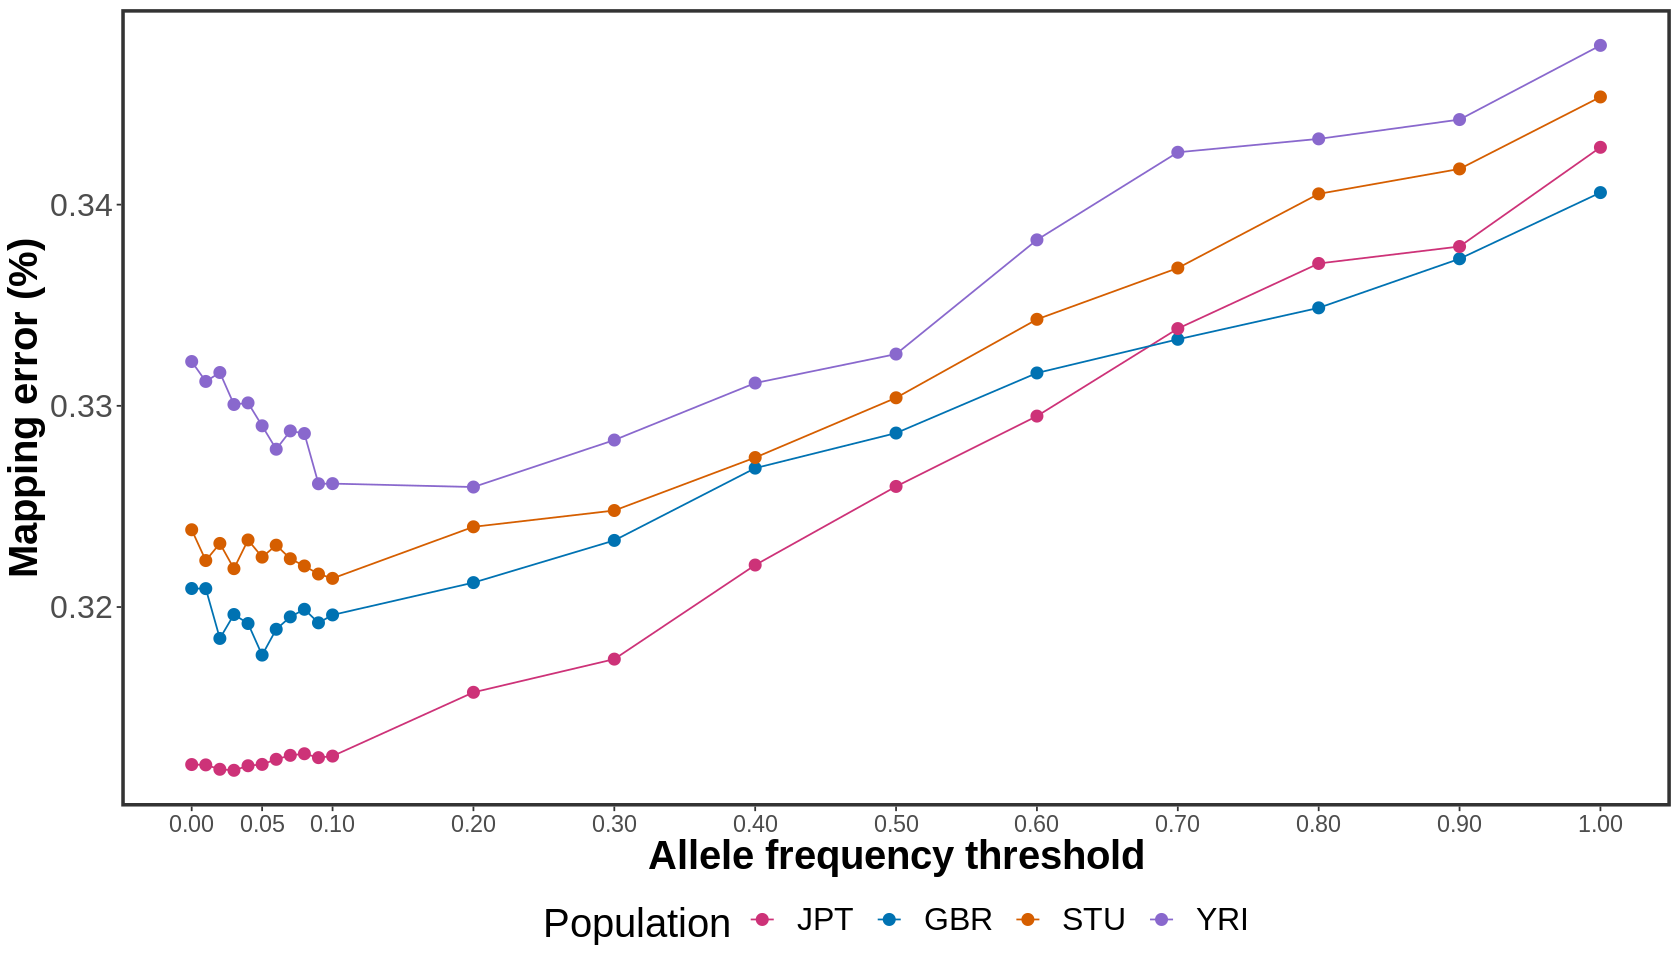

In [15]:
dathum_pe$humpop <- factor(dathum_pe$humpop,levels=c("JPT","GBR","STU","YRI"))

pl3  <- ggplot(dathum_pe,aes(x=af,y=incor2,col=humpop))+
  geom_point(size=3)+
  geom_line()+
  theme_bw()+
  scale_x_continuous(breaks = c(0,0.05,seq(0.1,1.1,0.1))) +
  theme(panel.border = element_rect(size=2),
        text=element_text(size=24),
        axis.title=element_text(face="bold"),
        axis.text.x=element_text(size=14),
        panel.grid=element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position = "bottom")+
  labs(x="Allele frequency threshold",y="Mapping error (%)",col="Population")+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))

pl3

### Plot of the TPR-FPR from the best graph from each population

We selected the best graph from each population and calculate TPR and FPR based on the mapping quality

In [16]:
# The table divided by allele frequency bin and corresponding TPR-FPR from each bin
datroc <- read.table(url(file.path(basepath,"best_roc_human.tsv")),header=TRUE,stringsAsFactors = FALSE)
datroc_pe  <- datroc  %>% filter(mode=="pe")
head(datroc_pe)

,bin,mq,FP,total,TP,TP_sum,FP_sum,total_sum,FPR,TPR,mode,population,prog,replication
,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,"(50,60]",59.991934,8,9848034,9848026,9848026,8,9848034,0.00008,98.48026,pe,GBR,vg,5
2,"(40,50]",44.988455,4,17496,17492,9865518,12,9865530,0.00012,98.65518,pe,GBR,vg,5
3,"(30,40]",35.846440,17,16124,16107,9881625,29,9881654,0.00029,98.81625,pe,GBR,vg,5
4,"(20,30]",25.697016,21,22252,22231,9903856,50,9903906,0.00050,99.03856,pe,GBR,vg,5
5,"(10,20]",14.840433,118,22724,22606,9926462,168,9926630,0.00168,99.26462,pe,GBR,vg,5
6,"[0,10]",1.541039,31659,73370,41711,9968173,31827,10000000,0.31827,99.68173,pe,GBR,vg,5


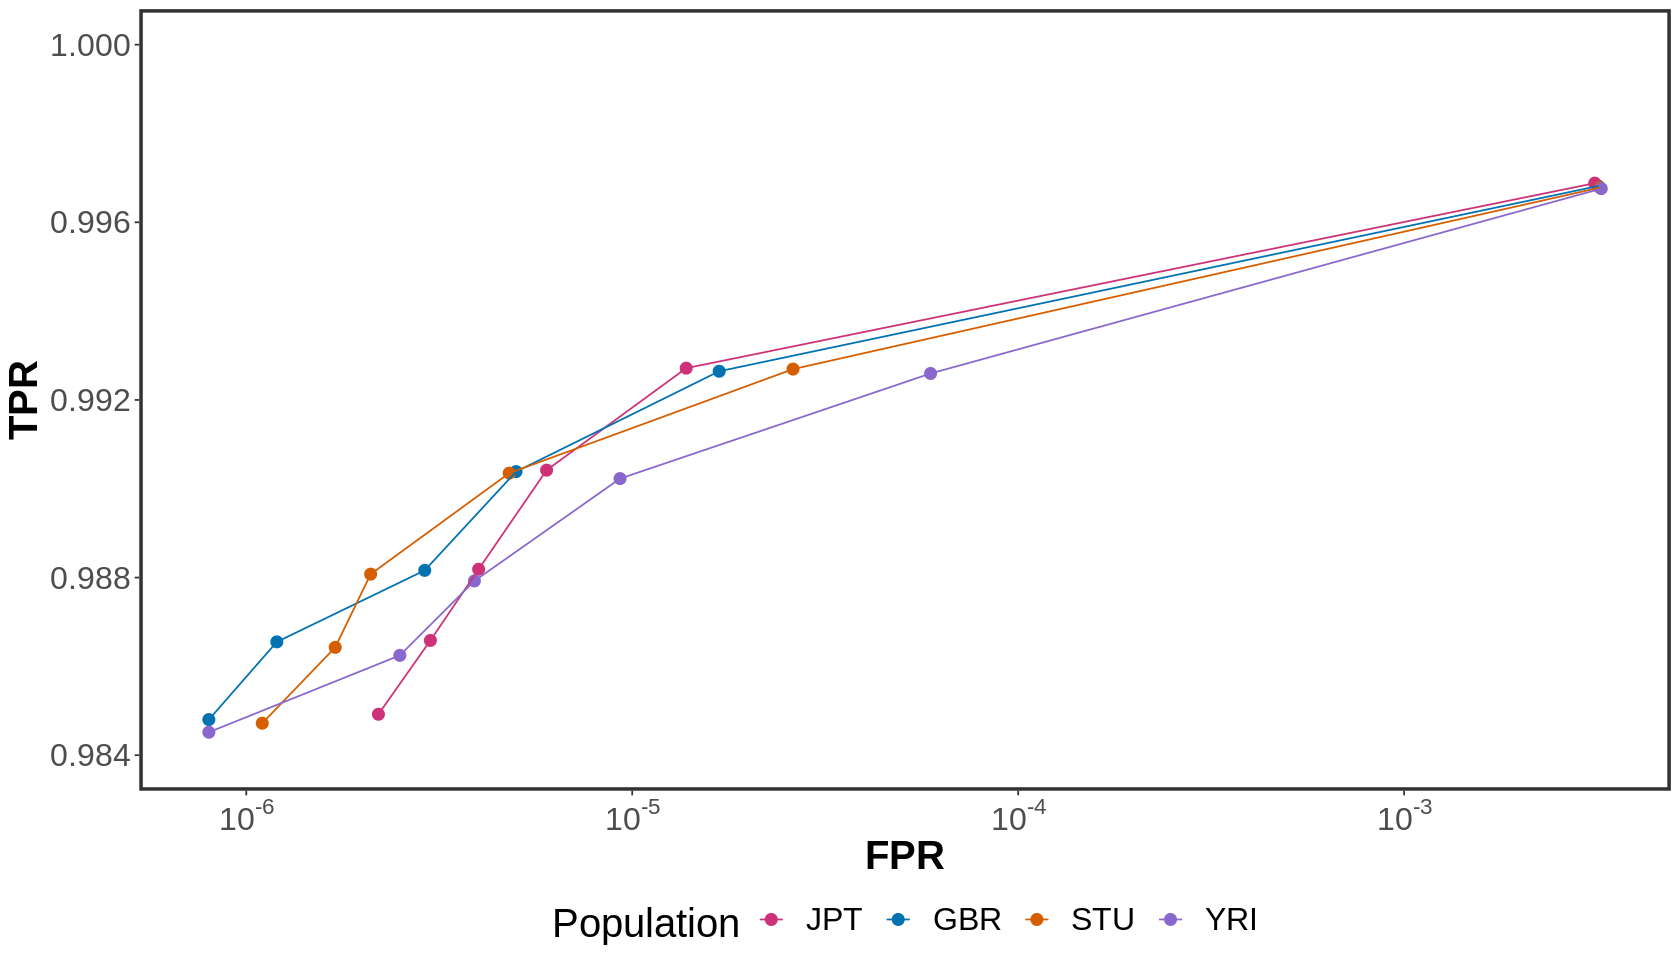

In [17]:
datroc_pe$population <- factor(datroc_pe$population,levels=c("JPT","GBR","STU","YRI"))

pl4 <- ggplot(datroc_pe,aes(x=FPR/100,y=TPR/100,col=population))+
  geom_point(size=3)+
  geom_line()+
  scale_x_log10(breaks=c(10^-6,10^-5,10^-4,10^-3,10^-2,10^-1,0),
                labels=scales::trans_format("log10",scales::math_format(10^.x)))+
  theme_bw()+
  scale_y_continuous(breaks=c(0.984,0.988,0.992,0.996,1.000),limits=c(0.984,1.000))+
  theme(panel.border = element_rect(size=2),
        text=element_text(size=24),
        axis.title=element_text(face="bold"),
        panel.grid=element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position = "bottom")+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))+
  guides(col = guide_legend(nrow = 1))+
  labs(x="FPR",y="TPR",col="Population")

pl4

### Comparison with random variant selection
We selected the random variants as the number of variants filtered based on frequency and look into the mapping profile.

In [18]:
##The data consists of breed, allele frequency threshold, incorrect mapping, and number of variants at given bin
datrand <- read.table(url(file.path(basepath,"random_af_human.tsv")),header = TRUE, stringsAsFactors = FALSE)
datsum <- datrand %>% group_by(af,maptype) %>% summarise(nc_pe=mean(pecor),
                                                 nc_se=mean(secor),
                                                 totvar=mean(totvar))
head(datrand)
head(datsum)

,af,population,secor,pecor,maptype,totvar
,<dbl>,<chr>,<int>,<int>,<chr>,<int>
1,0.01,GBR,63573,32331,random,203890
2,0.01,JPT,62864,31947,random,203890
3,0.01,STU,64646,32969,random,203890
4,0.01,YRI,67845,33488,random,203890
5,0.02,GBR,64172,32661,random,182713
6,0.02,JPT,63430,32073,random,182713


af,maptype,nc_pe,nc_se,totvar
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
0.00,af,32358.00,62971.00,290593
0.00,random,32409.75,63036.25,290593
0.01,af,32182.50,62950.75,203890
0.01,random,32683.75,64732.00,203890
0.02,af,32065.75,62805.75,182713
0.02,random,32909.25,65150.25,182713


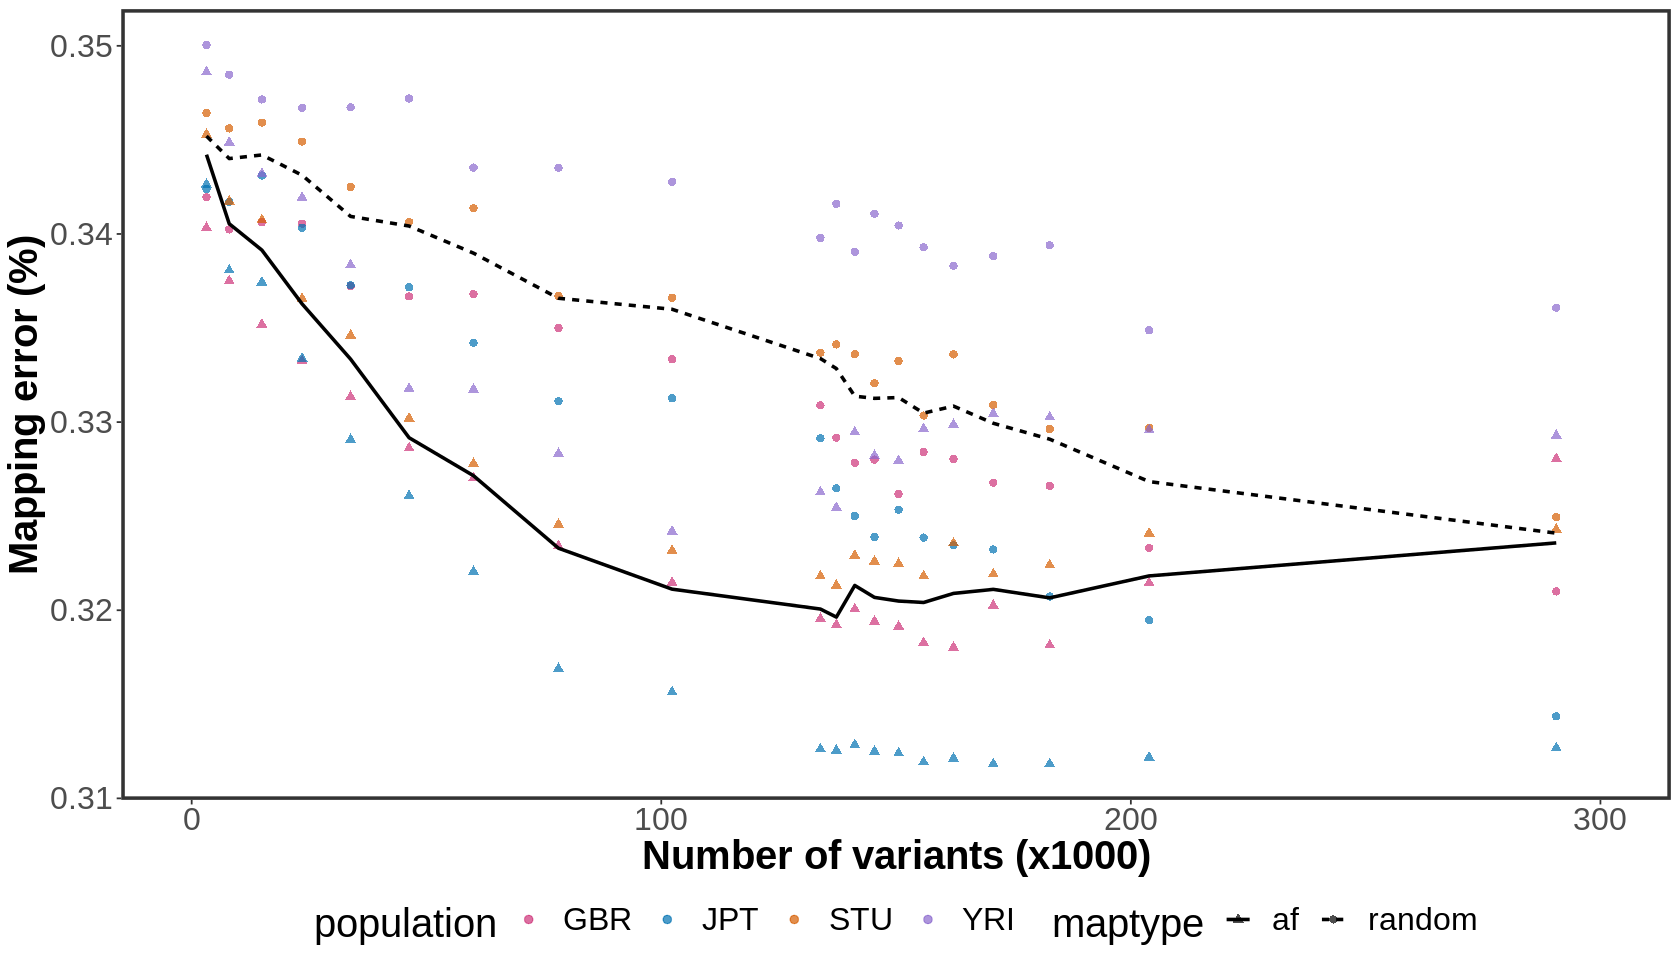

In [19]:
pl5  <-  ggplot(datrand,aes(x=totvar,y=pecor*10^2/10^7))+
  geom_point(aes(col=population,shape=maptype),size=2,alpha=0.7)+
  geom_line(data=datsum,aes(y=nc_pe*10^2/10^7,linetype=maptype),size=1)+
  theme_bw()+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))+
  theme(panel.border = element_rect(size=2),
        text = element_text(size=24),
        panel.grid = element_blank(),
        axis.title = element_text(face="bold"),
       legend.position="bottom")+
  scale_x_continuous(labels = c(0,100,200,300), limits = c(0,3*10^5))+
  scale_shape_manual(values=c(17,16)) +
  labs(x="Number of variants (x1000)",y="Mapping error (%)")

pl5

### Plotting the single-end results

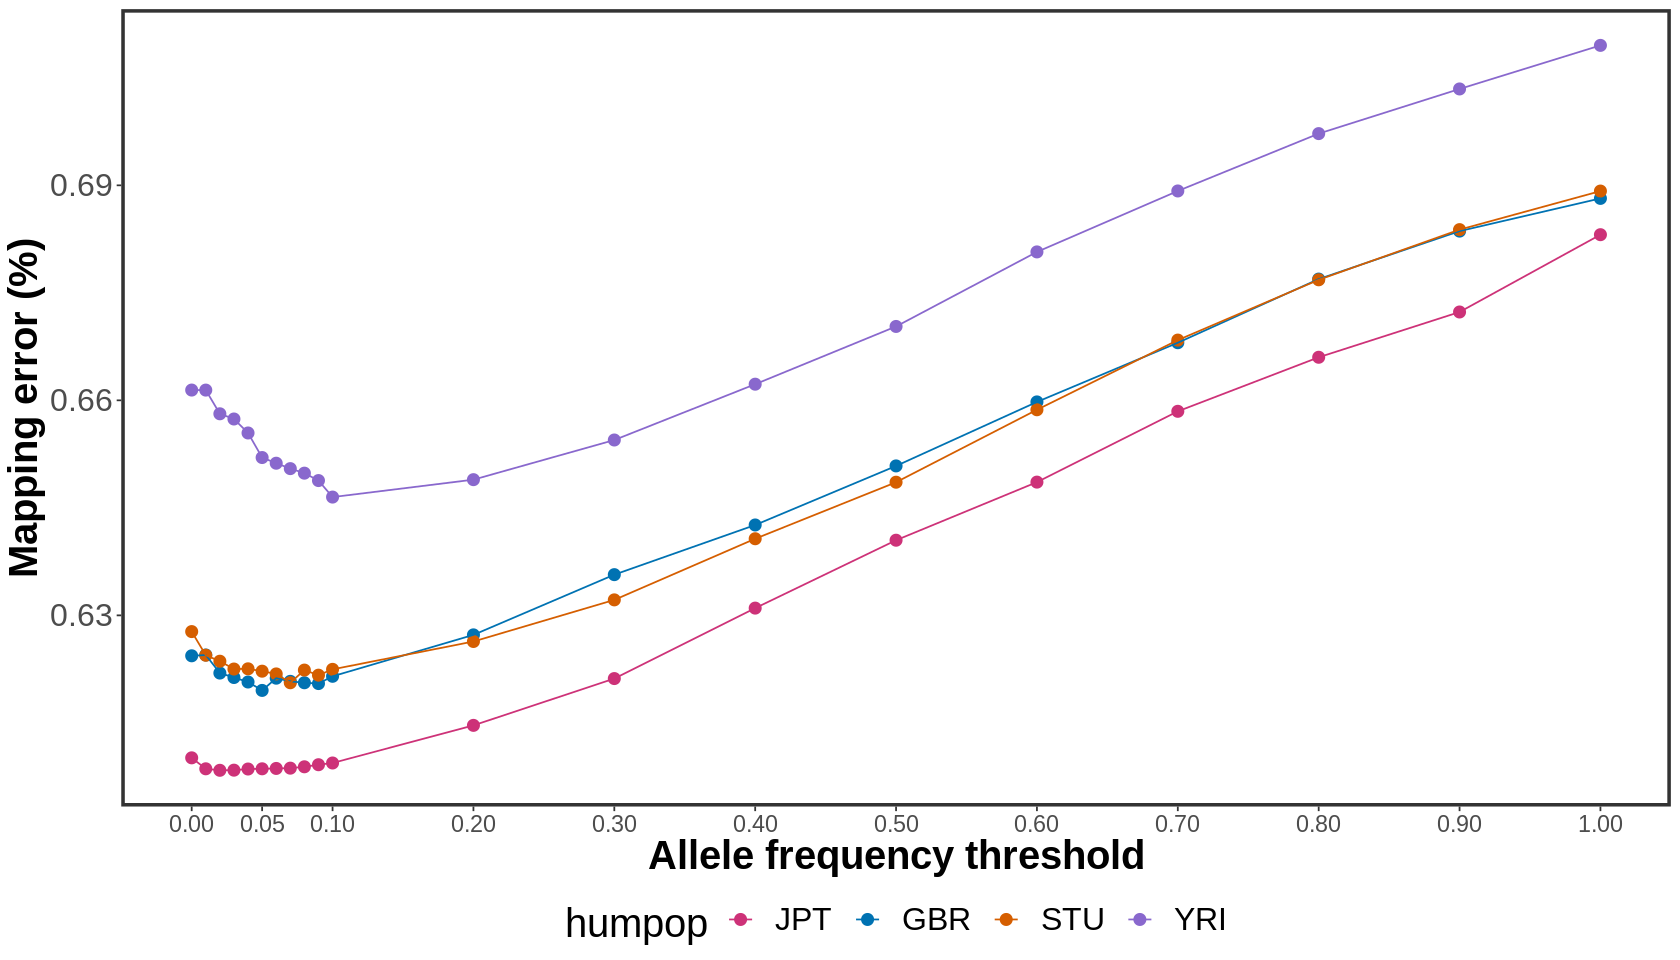

In [22]:
##af plot as in figure (pl3)
dathum_se  <- dathum  %>% select(humpop,afcor,secor2)
dathum_se$maptype  <- "se"
colnames(dathum_se)  <- c("humpop","af","incor2","maptype")
dathum_se$humpop <- factor(dathum_se$humpop,levels=c("JPT","GBR","STU","YRI"))

pl3_se  <- ggplot(dathum_se,aes(x=af,y=incor2,col=humpop))+
  geom_point(size=3)+
  geom_line()+
  theme_bw()+
  scale_x_continuous(breaks = c(0,0.05,seq(0.1,1.1,0.1))) +
  theme(panel.border = element_rect(size=2),
        text=element_text(size=24),
        axis.title=element_text(face="bold"),
        axis.text.x=element_text(size=14),
        panel.grid=element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position = "bottom")+
  labs(x="Allele frequency threshold",y="Mapping error (%)")+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))

pl3_se

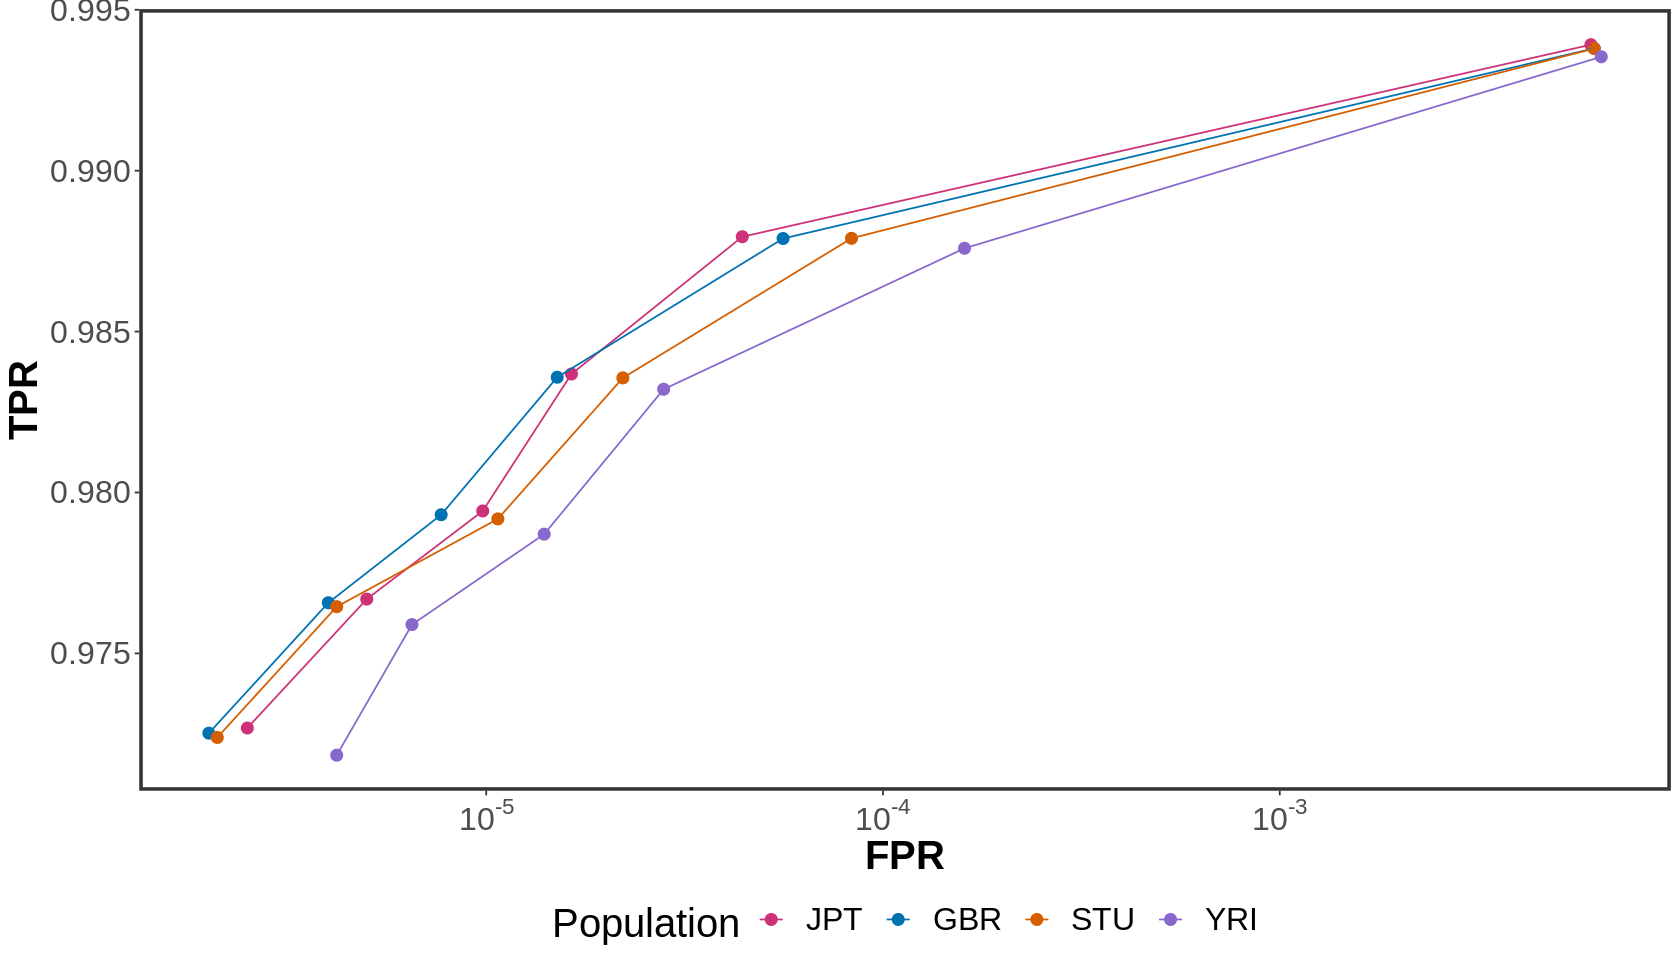

In [21]:
#tpr-fpr as in figure (pl) 4
datroc_se  <- datroc  %>% filter(mode=="se")
datroc_se$population <- factor(datroc_pe$population,levels=c("JPT","GBR","STU","YRI"))

pl4 <- ggplot(datroc_se,aes(x=FPR/100,y=TPR/100,col=population))+
  geom_point(size=3)+
  geom_line()+
  scale_x_log10(breaks=c(10^-6,10^-5,10^-4,10^-3,10^-2,10^-1,0),
                labels=scales::trans_format("log10",scales::math_format(10^.x)))+
  theme_bw()+
  theme(panel.border = element_rect(size=2),
        text=element_text(size=24),
        axis.title=element_text(face="bold"),
        panel.grid=element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position = "bottom")+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))+
  guides(col = guide_legend(nrow = 1))+
  labs(x="FPR",y="TPR",col="Population")

pl4

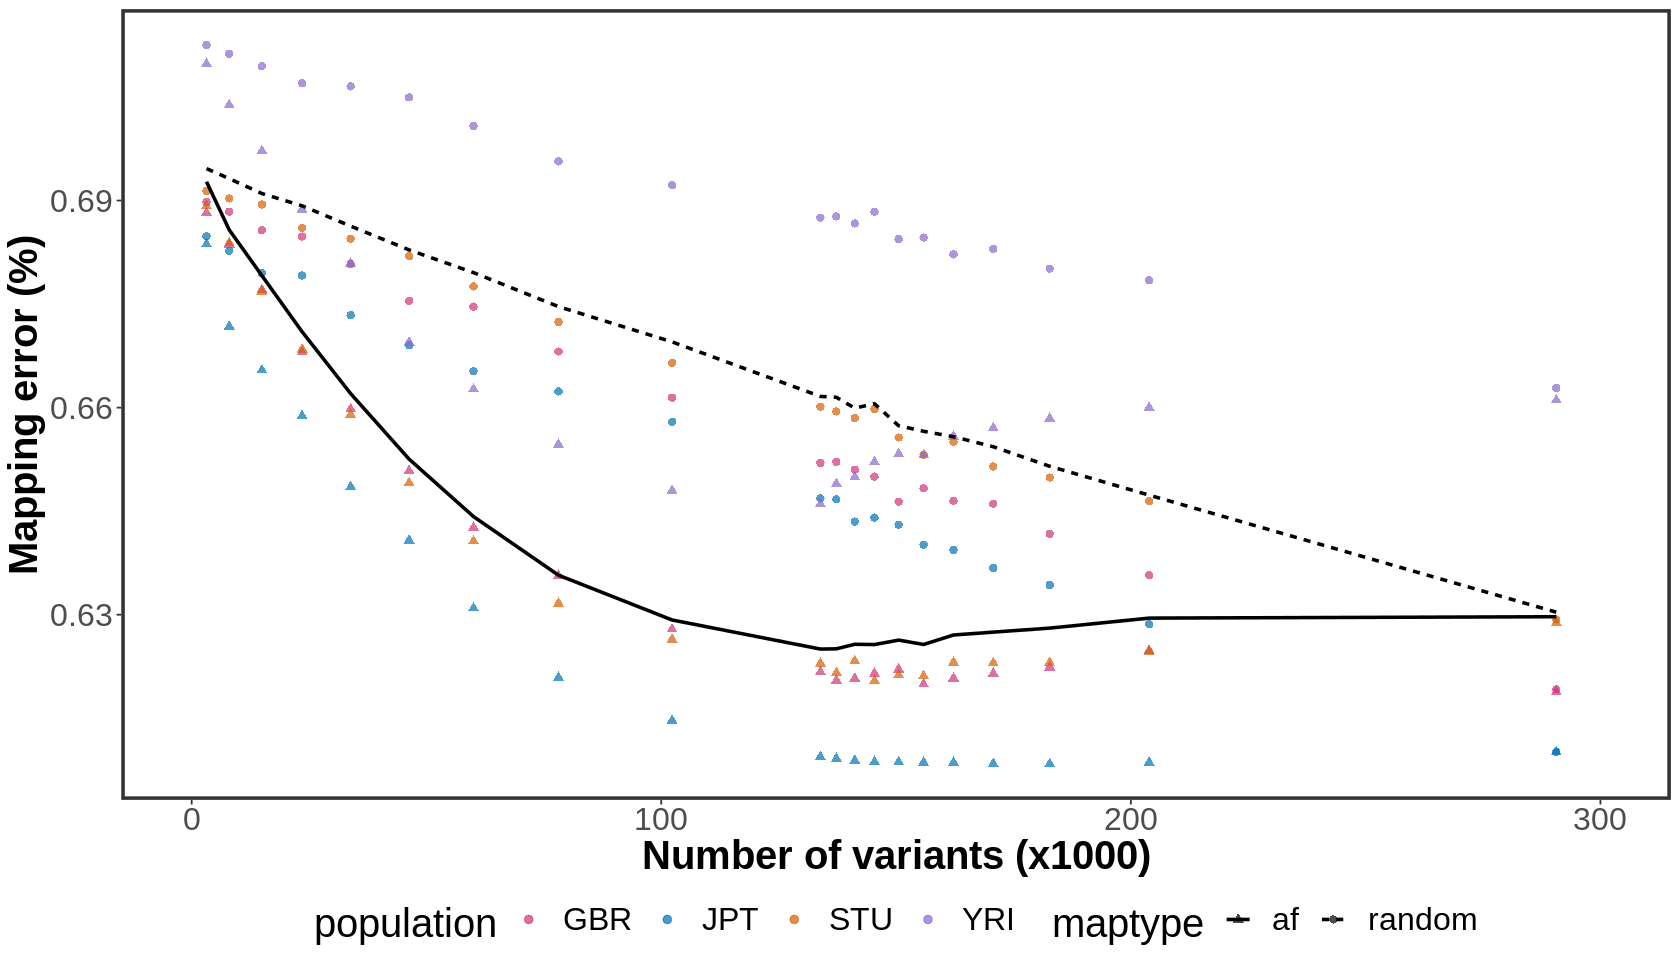

In [25]:
### random sampling plot as in figure (pl) 5
datrand <- read.table(url(file.path(basepath,"random_af_human.tsv")),header = TRUE, stringsAsFactors = FALSE)
datsum <- datrand %>% group_by(af,maptype) %>% summarise(nc_pe=mean(pecor),
                                                 nc_se=mean(secor),
                                                 totvar=mean(totvar))
pl5_se  <-  ggplot(datrand,aes(x=totvar,y=secor*10^2/10^7))+
  geom_point(aes(col=population,shape=maptype),size=2,alpha=0.7)+
  geom_line(data=datsum,aes(y=nc_se*10^2/10^7,linetype=maptype),size=1)+
  theme_bw()+
  scale_color_manual(values=c("violetred3","#0072B2", "#D55E00", "mediumpurple3"))+
  theme(panel.border = element_rect(size=2),
        text = element_text(size=24),
        panel.grid = element_blank(),
        axis.title = element_text(face="bold"),
        legend.position="bottom")+
  scale_x_continuous(labels = c(0,100,200,300), limits = c(0,3*10^5))+
  scale_shape_manual(values=c(17,16)) +
  labs(x="Number of variants (x1000)",y="Mapping error (%)")

pl5_se

In [24]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] magrittr_1.5    forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5    
 [5] purrr_0.3.3     readr_1.3.1     tidyr_1.0.2     tibble_3.0.0   
 [9] ggplot2_3.3.0   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_1.0.0 repr_1.1.0  